In [1]:
!pwd

/eos/home-i00/t/tmazuret/SWAN_projects/NMF_dials


## Importing libraries

In [2]:
# Setting up DIALS object and importing dqmexplore
import sys
sys.path.append("../DQMExplore/src/")

from utils.setupdials import setup_dials_object_deviceauth
dials = setup_dials_object_deviceauth()

import dqmexplore as dqme

[2024-09-20 07:16:48,961] INFO: Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2024-09-20 07:16:48,962] INFO: NumExpr defaulting to 8 threads.
[2024-09-20 07:16:49,944] INFO: This device will expire in 600 seconds.
[2024-09-20 07:16:49,946] INFO: Go to the following url and authenticate: https://auth.cern.ch/auth/realms/cern/device?user_code=OCAF-GWDC
[2024-09-20 07:16:49,947] INFO: Checking authorization status every 5 seconds...
[2024-09-20 07:16:55,507] INFO: Device authorized, authentication finished successfully!


In [3]:
# Importing DIALS objects
# For more information on DIALS, please visit https://github.com/cms-DQM/dials-py
from cmsdials.filters import LumisectionHistogram1DFilters, LumisectionHistogram2DFilters

# Importing other essential packages
import numpy as np
import pandas as pd

In [4]:
import cmsdials
from cmsdials.filters import OMSFilter, OMSPage

## Loading MEs information from the DIALS

In [5]:
mes_list = dials.mes.list(LumisectionHistogram1DFilters())
df_me = pd.DataFrame(mes_list)
tracking_mes = df_me[df_me.iloc[:, 1].apply(lambda x: 'Tracking' in x[1])]

pd.set_option('display.max_colwidth', None)
#df_me.iloc[:, 1].tail()
tracking_mes

,0,1,2,3
118,"(me_id, 10973340)","(me, Tracking/TrackParameters/generalTracks/GeneralProperties/Quality_GenTk)","(count, 441080)","(dim, 1)"
119,"(me_id, 10973341)","(me, Tracking/TrackParameters/generalTracks/GeneralProperties/TrackEtaHighpurity_ImpactPoint_GenTk)","(count, 441080)","(dim, 1)"
120,"(me_id, 10973342)","(me, Tracking/TrackParameters/generalTracks/GeneralProperties/TrackEtaLoose_ImpactPoint_GenTk)","(count, 441080)","(dim, 1)"
121,"(me_id, 10973343)","(me, Tracking/TrackParameters/generalTracks/GeneralProperties/TrackEtaTight_ImpactPoint_GenTk)","(count, 441080)","(dim, 1)"
122,"(me_id, 10973344)","(me, Tracking/TrackParameters/generalTracks/GeneralProperties/TrackPtLoose_ImpactPoint_GenTk)","(count, 441080)","(dim, 1)"
123,"(me_id, 10973345)","(me, Tracking/TrackParameters/generalTracks/GeneralProperties/TrackPtTight_ImpactPoint_GenTk)","(count, 441080)","(dim, 1)"
124,"(me_id, 10973346)","(me, Tracking/TrackParameters/highPurityTracks/pt_1/GeneralProperties/Chi2oNDF_GenTk)","(count, 441080)","(dim, 1)"
125,"(me_id, 10973347)","(me, Tracking/TrackParameters/highPurityTracks/pt_1/GeneralProperties/DistanceOfClosestApproachToBS_GenTk)","(count, 441080)","(dim, 1)"
126,"(me_id, 10973348)","(me, Tracking/TrackParameters/highPurityTracks/pt_1/GeneralProperties/DistanceOfClosestApproachToBSdz_GenTk)","(count, 441080)","(dim, 1)"
127,"(me_id, 10973349)","(me, Tracking/TrackParameters/highPurityTracks/pt_1/GeneralProperties/TrackEta_ImpactPoint_GenTk)","(count, 441080)","(dim, 1)"


In [6]:
runnb = 383948
runnb_test = 384318
me__regex =  "PixelPhase1/Tracks/PXBarrel/charge_PXLayer_1" 

data1D = dials.h1d.list_all(
    LumisectionHistogram1DFilters(
        run_number = runnb,
        dataset__regex = "ZeroBias",
        me__regex = me__regex
    ),
    max_pages=200
).to_pandas()

data1D_test = dials.h1d.list_all(
    LumisectionHistogram1DFilters(
        run_number = runnb_test,
        dataset__regex = "ZeroBias",
        me__regex = me__regex
    ),
    max_pages=200
).to_pandas()

In [7]:
from dqmexplore.dataproc import generate_me_dict

data1D_dict = generate_me_dict(data1D)
data1D_dict_test = generate_me_dict(data1D_test)
print(data1D_dict_test['PixelPhase1/Tracks/PXBarrel/charge_PXLayer_1']['data'])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


__https://tinyurl.com/2nj77jbs__ From RR (Not in use right now)

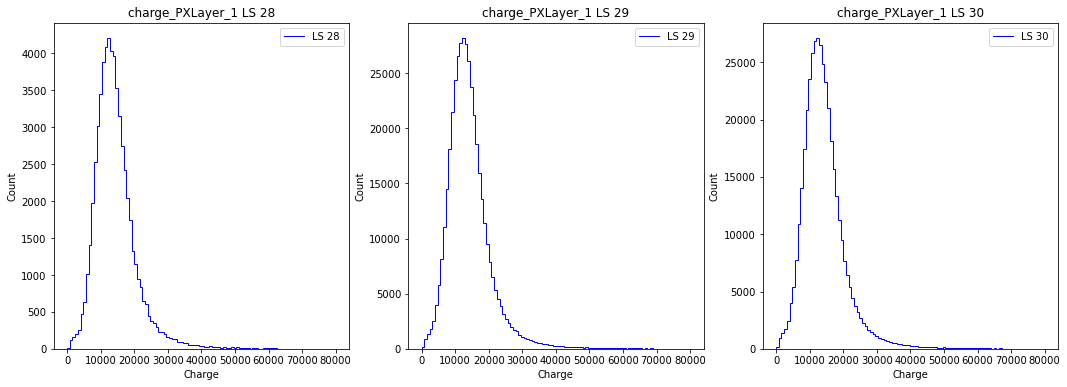

In [8]:
import matplotlib.pyplot as plt

data = data1D['data'].iloc[27:30]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

x_min = 0
x_max = 80000
x_bin = 100
bin_edges = np.linspace(x_min, x_max, x_bin + 1)

for i, (ax, (ls_number, charge)) in enumerate(zip(axes, data.items())):
    ax.stairs(charge, bin_edges, label=f'LS {ls_number+1}', color='b')
    ax.set_title('charge_PXLayer_1 LS {}'.format(ls_number+1))
    ax.set_xlabel('Charge')
    ax.set_ylabel('Count')
    ax.legend()
plt.show()


In [9]:
from dqmexplore.dataproc import trig_normalize
from dqmexplore.omsutils import get_rate

trig_rate = get_rate(dials, runnb, "ZeroBias")
# rtrn_np=True
trig_rate_test = get_rate(dials, runnb_test, "ZeroBias")
data1D_norm = trig_normalize(data1D_dict, trig_rate[:-2])
data1D_norm_test = trig_normalize(data1D_dict_test, trig_rate_test)

/eos/home-i00/t/tmazuret/SWAN_projects/NMF_dials/./DQMExplore/src/dqmexplore/dataproc.py:79: RuntimeWarning: divide by zero encountered in divide
  data_dict[me]["data"] = data_dict[me]["data"] / trigger_rates[:, np.newaxis]


In [10]:
df_trig = pd.DataFrame(data1D_norm['PixelPhase1/Tracks/PXBarrel/charge_PXLayer_1']["data"])
rows_as_lists = df_trig.apply(lambda row: row.tolist(), axis=1)

df_trig_test = pd.DataFrame(data1D_norm_test['PixelPhase1/Tracks/PXBarrel/charge_PXLayer_1']["data"])
rows_as_lists_test = df_trig_test.apply(lambda row: row.tolist(), axis=1)

df_after_trig = pd.DataFrame({'data': rows_as_lists})
df_after_trig_test = pd.DataFrame({'data': rows_as_lists_test})
#df_after_trig.iloc[40:45]
#print(type(df_after_trig.loc[1724]))
#df_after_trig.iloc[20:30]

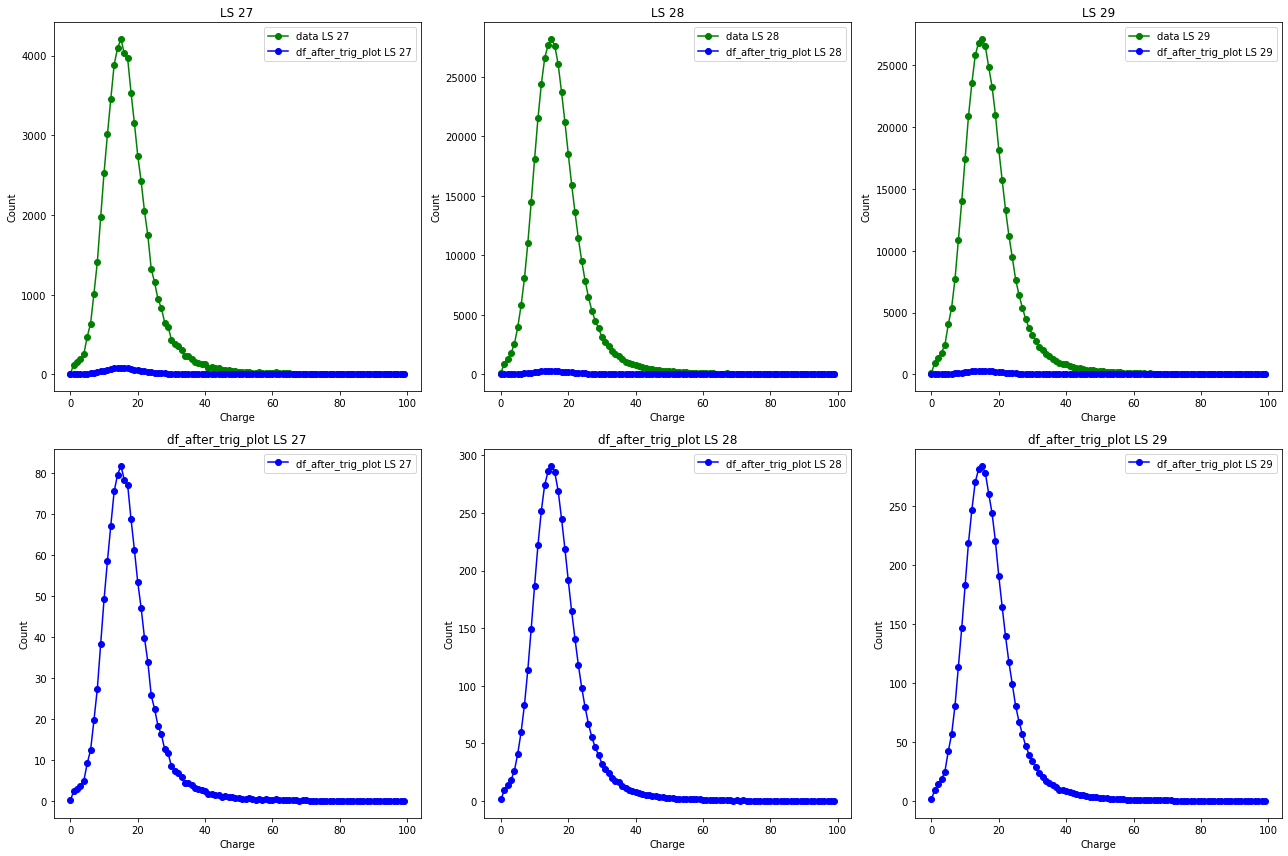

In [11]:
data = data1D['data'].iloc[27:30]
df_after_trig_plot = df_after_trig['data'].iloc[27:30]

ls_indices = data.index 

fig, axes = plt.subplots(2, 3, figsize=(18, 12)) 

# Plot the first row: data vs df_after_trig_plot
for i in range(3):
    ls_number = ls_indices[i]  
    axes[0, i].plot(data.iloc[i], marker='o', linestyle='-', color='g', label=f'data LS {ls_number}')
    axes[0, i].plot(df_after_trig_plot.iloc[i], marker='o', linestyle='-', color='b', label=f'df_after_trig_plot LS {ls_number}')
    
    axes[0, i].set_title(f'LS {ls_number}')  
    axes[0, i].set_xlabel('Charge')
    axes[0, i].set_ylabel('Count')
    axes[0, i].legend()

# Plot the second row: only df_after_trig_plot
for i in range(3):
    ls_number = ls_indices[i] 
    axes[1, i].plot(df_after_trig_plot.iloc[i], marker='o', linestyle='-', color='b', label=f'df_after_trig_plot LS {ls_number}')
    
    axes[1, i].set_title(f'df_after_trig_plot LS {ls_number}')
    axes[1, i].set_xlabel('Charge')
    axes[1, i].set_ylabel('Count')
    axes[1, i].legend()

plt.tight_layout()
plt.show()


In [12]:
import math

def contains_only_zeros_nan_or_inf(lst):
    return all(x == 0 for x in lst) or any(math.isnan(x) for x in lst) or any(math.isinf(x) for x in lst)


# Filter 'data' lists from zero lists
df_filtered = df_after_trig[~df_after_trig['data'].apply(contains_only_zeros_nan_or_inf)]

df_filtered_test = df_after_trig_test[~df_after_trig_test['data'].apply(contains_only_zeros_nan_or_inf)]

#df_filtered.head(1)

In [13]:
data_lists = df_filtered['data'].tolist()
data_lists_test = df_filtered_test['data'].tolist()

In [14]:
from sklearn.decomposition import NMF

dense_matrix = np.array(data_lists)
dense_matrix_test = np.array(data_lists_test)

# Initialize and fit the NMF model
model = NMF(n_components=4, init='random', random_state=10, verbose = True)
W = model.fit_transform(dense_matrix)
H = model.components_

# Reconstructed trained data
reconstructed_matrix_train = np.dot(W, H)

# Transformation of the test data
W_test = model.transform(dense_matrix_test)

# Reconstruction of the test data
reconstructed_matrix_test = np.dot(W_test, H)

print("\nW (Basis Matrix for Training Data):")
print(W)

print("\nH (Coefficient Matrix for Training Data):")
print(H)

print("\nReconstructed Training Matrix:")
print(reconstructed_matrix_train)

print("\nOriginal Test Matrix (Dense):")
print(dense_matrix_test)

print("\nW_test (Basis Matrix for Test Data):")
print(W_test)

print("\nReconstructed Test Matrix:")
print(reconstructed_matrix_test)

violation: 1.0
violation: 0.012798919312246386
violation: 0.0018423519526172417
violation: 0.0009043620675453937
violation: 0.0006085632502916343
violation: 0.0005319907865401921
violation: 0.0004883378219657523
violation: 0.0004808633885374202
violation: 0.0004807169694350853
violation: 0.0004846669781977381
violation: 0.0004913940757755256
violation: 0.0004997312243616885
violation: 0.0005095462311868133
violation: 0.0005205396216118723
violation: 0.0005324046004195288
violation: 0.000544778529145553
violation: 0.0005574960654753525
violation: 0.000569979065312277
violation: 0.0005821739716302517
violation: 0.0005934073303828763
violation: 0.0006029961563529978
violation: 0.0006108972095143711
violation: 0.0006128249317600087
violation: 0.0006189397430565605
violation: 0.0006244554595598302
violation: 0.0006277250880996673
violation: 0.0006275794511843752
violation: 0.0006270363605240833
violation: 0.00061452769525405
violation: 0.0006067627631130347
violation: 0.0005965454247209128


In [15]:
from sklearn.metrics import mean_squared_error

# Calculate error for training data
train_error = mean_squared_error(dense_matrix, reconstructed_matrix_train)

# Calculate error for test data
test_error = mean_squared_error(dense_matrix_test, reconstructed_matrix_test)

print(f'Training Error: {train_error}')
print(f'Test Error: {test_error}')

Training Error: 1.6822876686665844
Test Error: 19.206192308974618


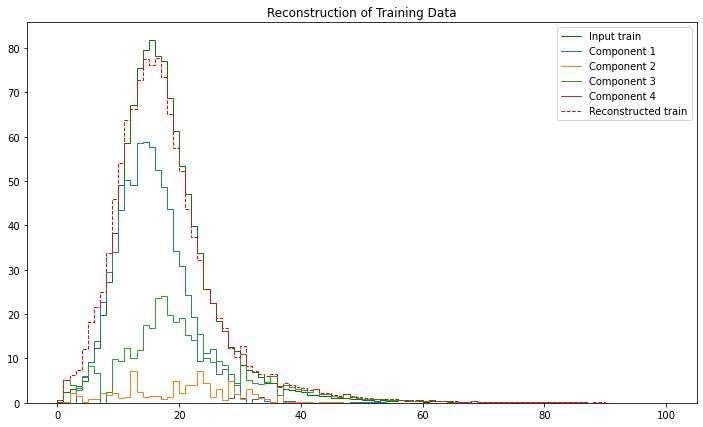

In [16]:
sample_idx = 0  

plt.figure(figsize=(12, 7))
plt.stairs(dense_matrix[sample_idx], label='Input train', color="g")

# Reconstructed data from W * H for each component
reconstructed_sample = np.dot(W[sample_idx, :], H)

# Individual components and the reconstruction
for i in range(H.shape[0]):
    # Component contribution to the input
    component_contribution = W[sample_idx, i] * H[i]
    plt.stairs(component_contribution, label=f'Component {i+1}')

plt.stairs(reconstructed_sample, label='Reconstructed train', linestyle='--', color='r')

plt.legend()
plt.title(f"Reconstruction of Training Data")

plt.show()


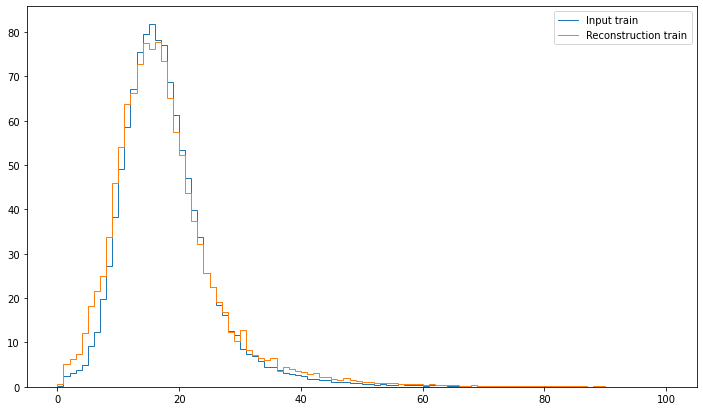

In [17]:
# Compare original and reconstructed data for training
plt.figure(figsize=(12, 7))
plt.stairs(dense_matrix[0], label='Input train')
plt.stairs(reconstructed_matrix_train[0], label='Reconstruction train')
plt.legend()
plt.show()


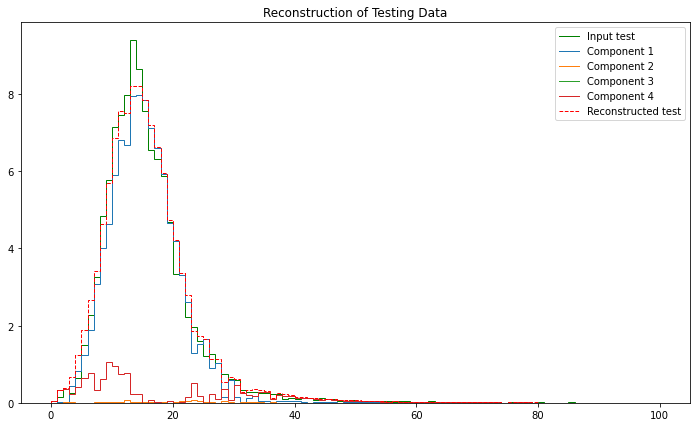

In [18]:
sample_idx = 0  

plt.figure(figsize=(12, 7))
plt.stairs(dense_matrix_test[sample_idx], label='Input test', color="g")

# Reconstructed data from W * H for each component
reconstructed_sample_test = np.dot(W_test[sample_idx, :], H)

# Individual components and the reconstruction
for i in range(H.shape[0]):
    # Component contribution to the input
    component_contribution_test = W_test[sample_idx, i] * H[i]
    plt.stairs(component_contribution_test, label=f'Component {i+1}')

plt.stairs(reconstructed_sample_test, label='Reconstructed test', linestyle='--', color='r')

plt.legend()
plt.title(f"Reconstruction of Testing Data")

plt.show()

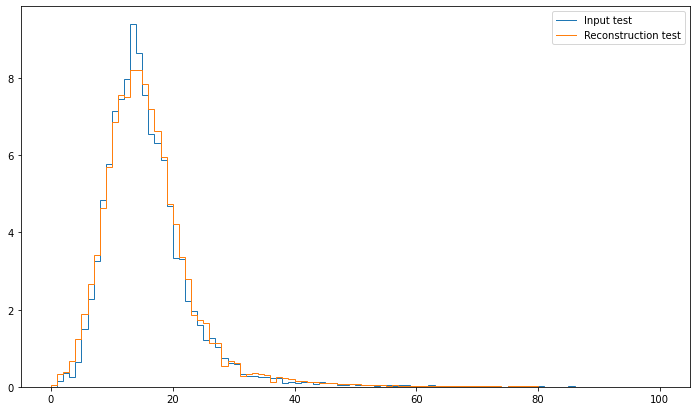

In [19]:
plt.figure(figsize=(12, 7))
plt.stairs(dense_matrix_test[0], label='Input test')
plt.stairs(reconstructed_matrix_test[0], label='Reconstruction test')
plt.legend()
plt.show()

In [20]:
df_reco_1 = pd.DataFrame(reconstructed_matrix_train)
data1D_reco = pd.DataFrame({'data': df_reco_1.values.tolist()})
df_reco_1_test = pd.DataFrame(reconstructed_matrix_test)
data1D_reco_test = pd.DataFrame({'data': df_reco_1_test.values.tolist()})

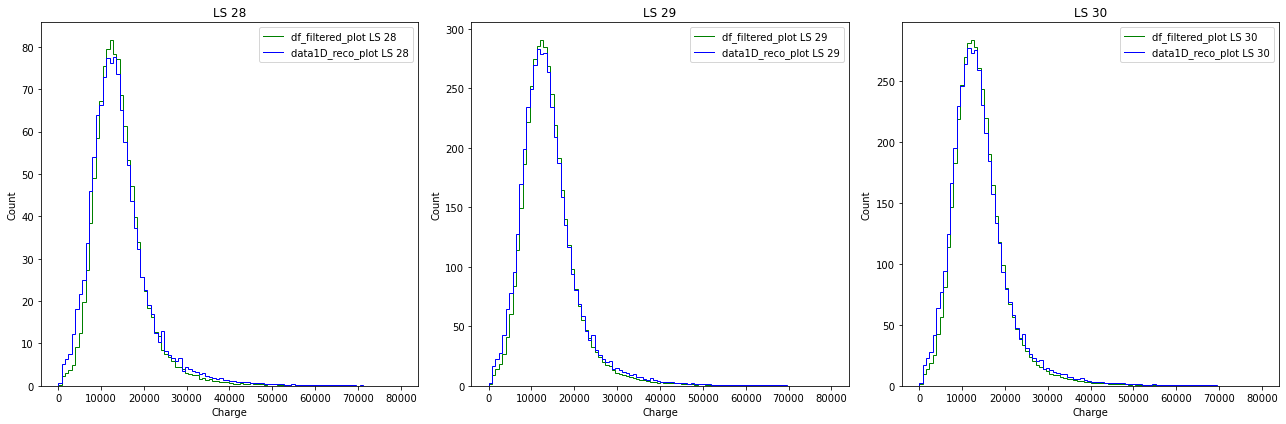

In [21]:
data1D_reco_plot = data1D_reco['data'].iloc[:3]
df_filtered_plot = df_filtered['data'].iloc[:3]
ls_indices = df_filtered.index[:3]

x_min = 0
x_max = 80000
x_bin = 100
bin_edges = np.linspace(x_min, x_max, x_bin + 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i in range(3):
    ls_number = ls_indices[i]
    
    axes[i].stairs(df_filtered_plot.iloc[i], bin_edges, color='g', label=f'df_filtered_plot LS {ls_number+1}')
    
    axes[i].stairs(data1D_reco_plot.iloc[i], bin_edges, color='b', label=f'data1D_reco_plot LS {ls_number+1}')
    
    axes[i].set_title(f'LS {ls_number+1}')
    axes[i].set_xlabel('Charge')
    axes[i].set_ylabel('Count')
    
    axes[i].legend()

plt.tight_layout()
plt.show()


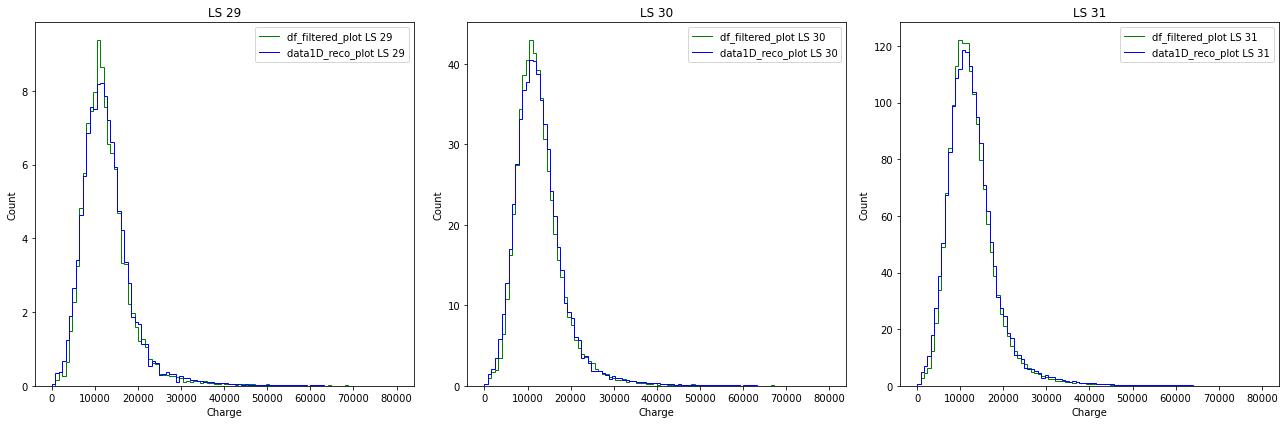

In [22]:
data1D_reco_plot_test = data1D_reco_test['data'].iloc[:3]
df_filtered_plot_test = df_filtered_test['data'].iloc[:3]
ls_indices_test = df_filtered_test.index[:3] 

x_min = 0
x_max = 80000
x_bin = 100
bin_edges = np.linspace(x_min, x_max, x_bin + 1)  

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i in range(3):
    ls_number = ls_indices_test[i]  
    
    axes[i].stairs(df_filtered_plot_test.iloc[i], bin_edges, color='g', label=f'df_filtered_plot LS {ls_number+1}')
    
    axes[i].stairs(data1D_reco_plot_test.iloc[i], bin_edges, color='b', label=f'data1D_reco_plot LS {ls_number+1}')
    
    axes[i].set_title(f'LS {ls_number+1}')
    axes[i].set_xlabel('Charge')
    axes[i].set_ylabel('Count')
    
    axes[i].legend()

plt.tight_layout()
plt.show()
